In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import re
import models_mae
from matplotlib import pyplot as plt

def prepare_model(chkpt_dir, arch='mae_vit_base_patch1', **kwargs):
    model = getattr(models_mae, arch)(**kwargs)
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print("[Loaded]", msg)
    model.eval()
    return model

def inverse_normalize(log_normalized_values):
    # original_min = 370
    # original_max = 1800
    original_min = 300
    original_max = 1600
    log_values = log_normalized_values * (np.log(original_max) - np.log(original_min)) + np.log(original_min)
    return np.exp(log_values)

def run_one_clip(clip_np, model, mask_ratio=0.5, custom_mask=None):
    frames_tensor = torch.tensor(clip_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    with torch.no_grad():
        loss, pred, mask = model(frames_tensor, mask_ratio=mask_ratio, custom_mask=custom_mask)
        # print("Loss:", loss)

    # 將預測結果與 mask 還原成影像
    pred_img = model.unpatchify(pred).detach().cpu()
    mask = mask.detach().unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2)
    mask = model.unpatchify(mask).detach().cpu()

    # masked regions = pred, unmasked regions = original
    im_paste = frames_tensor * (1 - mask) + pred_img * mask

    T_pred = model.pred_t_dim
    original = frames_tensor.detach().cpu().numpy()[0, 0, :T_pred]      # (T, H, W)
    predicted = im_paste.numpy()[0, 0, :T_pred]                          # (T, H, W)
    mask_np = mask[0, 0, :T_pred].numpy()                                # (T, H, W)

    # inverse normalize
    orig_inv = inverse_normalize(original.flatten()).reshape(original.shape)
    pred_inv = inverse_normalize(predicted.flatten()).reshape(predicted.shape)

    # relative error only in masked regions
    relative_error = np.abs((orig_inv - pred_inv) / orig_inv)
    relative_error[mask_np != 1] = np.nan

    return orig_inv, pred_inv, relative_error, mask_np

# === Main execution ===
# data_dir = 'biya_cfd_data/test_base' # ablation study base
# data_dir = 'biya_cfd_data/test_new'   # ablation study fan
# data_dir = 'cfd_dataset_origin/53_ablation/test' # ablation study transfer

# data_dir = 'cfd_dataset_origin/test' #result CFD
# data_dir = 'biya_exp_data/test' #result CFD

# data_dir = 'biya_exp_data/dataset_ablation55/train'
# data_dir = 'biya_exp_data/dataset_ablation55/EXP_test'
# data_dir = 'biya_exp_data/dataset_ablation55/same_cfd_test'
# data_dir = 'biya_exp_data/dataset_ablation55/fan_change_cfd_test'
# data_dir = 'biya_exp_data/dataset_ablation55/con_change_cfd_test'
data_dir = 'biya_exp_data/dataset_ablation55/position_change_cfd_test'


save_path = 'output_csv'
os.makedirs(save_path, exist_ok=True)

sampling_rate = 1
csv_files = sorted([
    os.path.join(data_dir, f)
    for f in os.listdir(data_dir)
    if f.endswith('.csv')
], key=lambda path: int(re.match(r".*_(\d+)", os.path.basename(path)).group(1)))[::sampling_rate]

model = prepare_model(

    # 'new_exp_output_16/checkpoint-00200.pth',
    # 'origin_cfd_output_16/checkpoint-00200.pth',

    # 'output_dir_ablation53/checkpoint-00200.pth',
    # 'output_dir_ablation53/checkpoint-00800.pth',
    # 'output_dir_ablation53_notransfer/checkpoint-00200.pth',

    # 'fan_cfd_output_16/checkpoint-00200.pth',

    # 'output_dir_25-50/checkpoint-00200.pth',
    # 'output_dir_25-75/checkpoint-00200.pth',

    'output_dir_ablation55/checkpoint-00300.pth',

    arch='mae_vit_base_patch1',
    in_chans=1,
    t_patch_size=1,
    pred_t_dim=8,
    num_frames=8,
)

num_frames = 8    # ✅ 修改輸入幀數
step = model.pred_t_dim     # 每次前進的步數取決於預測幾幀

# 修改 run_one_clip() 以支援多幀預測
def run_one_clip(clip_np, model, mask_ratio=0.5, custom_mask=None):
    frames_tensor = torch.tensor(clip_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, T, H, W)

    with torch.no_grad():
        loss, pred, mask = model(frames_tensor, mask_ratio=mask_ratio, custom_mask=custom_mask)

    pred_img = model.unpatchify(pred).detach().cpu()          # (1, 1, T_pred, H, W)
    mask = mask.detach().unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2)
    mask = model.unpatchify(mask).detach().cpu()              # (1, 1, T_pred, H, W)

    im_paste = frames_tensor * (1 - mask) + pred_img * mask

    T_pred = model.pred_t_dim
    original = frames_tensor[0, 0, :T_pred].numpy()
    predicted = im_paste[0, 0, :T_pred].numpy()
    mask_np = mask[0, 0, :T_pred].numpy()

    orig_inv = inverse_normalize(original.flatten()).reshape(original.shape)
    pred_inv = inverse_normalize(predicted.flatten()).reshape(predicted.shape)

    relative_error = np.abs((orig_inv - pred_inv) / orig_inv)
    relative_error[mask_np != 1] = np.nan

    return orig_inv, pred_inv, relative_error, mask_np

# 處理每個片段
all_result = []
for i in range(0, len(csv_files) - num_frames + 1, step):  # ✅ 保證每段都有足夠幀數
    files = csv_files[i:i+num_frames]
    clip = [np.genfromtxt(f, delimiter=',') for f in files]
    clip_np = np.stack(clip)  # (T, H, W)


    # custom_mask = torch.tensor([1,0,1,0, 0,1,0,1, 1,0,1,0, 0,1,0,1], dtype=torch.int)
    # custom_mask = torch.tensor([0,1,0,1, 1,0,1,0, 0,1,0,1, 1,0,1,0], dtype=torch.int)

    # CFD 僅改變濃度變化
    # custom_mask = torch.tensor([0,1,1,1, 1,1,0,1, 1,1,0,1, 1,0,1,0], dtype=torch.int) # CFD最佳
    # custom_mask = torch.tensor([0,1,1,1, 1,1,0,0, 1,1,0,1, 1,0,1,0], dtype=torch.int) # CFD等高線

    # EXP
    # custom_mask = torch.tensor([1,1,1,1, 1,1,1,1, 1,1,1,1, 1,1,1,1], dtype=torch.int) # 0
    # custom_mask = torch.tensor([1,1,1,1, 0,1,1,1, 1,1,1,1, 1,1,1,1], dtype=torch.int) # 1
    # custom_mask = torch.tensor([1,1,1,1, 0,0,1,1, 1,1,1,1, 1,1,1,1], dtype=torch.int) # 2
    # custom_mask = torch.tensor([1,1,1,1, 0,0,1,1, 1,0,1,1, 1,1,1,1], dtype=torch.int) # 3
    # custom_mask = torch.tensor([1,1,1,1, 0,0,1,1, 1,0,1,1, 0,1,1,1], dtype=torch.int) # 4
    # custom_mask = torch.tensor([1,1,1,1, 0,0,0,1, 1,0,1,1, 0,1,1,1], dtype=torch.int) # 5
    # custom_mask = torch.tensor([1,1,1,1, 0,0,0,1, 0,0,1,1, 0,1,1,1], dtype=torch.int) # 6
    # custom_mask = torch.tensor([1,1,1,1, 0,0,0,1, 0,0,1,1, 0,1,0,1], dtype=torch.int) # 7
    # custom_mask = torch.tensor([1,1,0,1, 0,0,0,1, 0,0,1,1, 0,1,0,1], dtype=torch.int) # 8

    # CFD-exp
    # custom_mask = torch.tensor([1,1,1,1, 1,1,1,1, 1,1,1,1, 1,1,1,1], dtype=torch.int) # 0
    # custom_mask = torch.tensor([1,1,1,1, 1,1,1,1, 1,1,1,1, 1,0,1,1], dtype=torch.int) # 1
    # custom_mask = torch.tensor([1,1,1,1, 0,1,1,1, 1,0,1,1, 1,1,1,1], dtype=torch.int) # 2
    # custom_mask = torch.tensor([1,1,1,1, 0,1,0,1, 1,0,1,1, 1,1,1,1], dtype=torch.int) # 3
    # custom_mask = torch.tensor([1,1,1,1, 0,1,0,1, 0,0,1,1, 1,1,1,1], dtype=torch.int) # 4
    # custom_mask = torch.tensor([1,1,1,1, 0,1,0,1, 0,0,0,1, 1,1,1,1], dtype=torch.int) # 5
    # custom_mask = torch.tensor([1,1,1,1, 0,1,0,1, 0,0,0,0, 1,1,1,1], dtype=torch.int) # 6
    # custom_mask = torch.tensor([1,1,1,1, 0,1,0,0, 0,0,0,0, 1,1,1,1], dtype=torch.int) # 7
    # custom_mask = torch.tensor([1,1,1,1, 0,1,0,0, 0,0,0,0, 1,1,1,0], dtype=torch.int) # 8

    # ablation study base
    # custom_mask = torch.tensor([1,1,1,1, 1,1,1,1, 1,1,1,1, 1,1,1,1], dtype=torch.int) # 0
    # custom_mask = torch.tensor([1,1,1,1, 1,1,1,1, 0,1,1,1, 1,1,1,1], dtype=torch.int) # 1
    # custom_mask = torch.tensor([1,1,1,1, 1,1,1,1, 0,1,1,1, 1,1,1,0], dtype=torch.int) # 2
    # custom_mask = torch.tensor([1,1,1,1, 1,1,1,1, 0,1,1,1, 0,1,1,0], dtype=torch.int) # 3
    # custom_mask = torch.tensor([1,1,1,1, 1,1,0,1, 0,1,1,1, 0,1,1,0], dtype=torch.int) # 4
    # custom_mask = torch.tensor([1,1,1,1, 1,0,0,1, 0,1,1,1, 0,1,1,0], dtype=torch.int) # 5
    # custom_mask = torch.tensor([0,1,1,1, 1,0,0,1, 0,1,1,1, 0,1,1,0], dtype=torch.int) # 6
    # custom_mask = torch.tensor([0,1,1,1, 1,0,0,1, 0,1,1,1, 0,0,1,0], dtype=torch.int) # 7
    # custom_mask = torch.tensor([0,1,1,1, 0,0,0,1, 0,1,1,1, 0,0,1,0], dtype=torch.int) # 8

    # custom_mask = torch.tensor([0,1,0,1, 1,0,1,0, 0,1,0,1, 1,0,1,0], dtype=torch.int) # grid8 1
    # custom_mask = torch.tensor([1,0,1,0, 0,1,0,1, 1,0,1,0, 0,1,0,1], dtype=torch.int) # grid8 2
    # custom_mask = torch.tensor([1,1,0,1, 1,0,1,1, 1,1,0,1, 1,0,1,1], dtype=torch.int) # grid4
    # custom_mask = torch.tensor([1,0,1,1, 1,1,0,1, 1,0,1,1, 1,1,0,1], dtype=torch.int) # grid4
    # custom_mask = torch.tensor([1,1,0,1, 1,1,1,1, 1,1,1,1, 1,0,1,1], dtype=torch.int) # grid2
    custom_mask = torch.tensor([0,1,1,1, 1,1,1,1, 1,1,1,1, 1,1,1,0], dtype=torch.int) # grid2


    # ablation study transfer
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], dtype=torch.int)

    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1], dtype=torch.int)
    # custom_mask = torch.tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1], dtype=torch.int)

    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=torch.int)
    
    # 25-50
    # custom_mask = torch.tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0], dtype=torch.int)
    # custom_mask = torch.tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=torch.int)
    # custom_mask = torch.tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=torch.int)
    # custom_mask = torch.tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=torch.int)
    # custom_mask = torch.tensor([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=torch.int)

    # 25-75
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0], dtype=torch.int)
    # custom_mask = torch.tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0], dtype=torch.int)
    # custom_mask = torch.tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0], dtype=torch.int)



    orig, pred, err, mask_np = run_one_clip(clip_np, model, mask_ratio=0.5, custom_mask=custom_mask)

    for t in range(model.pred_t_dim):
        record = {}
        pred_flat = pred[t].flatten()
        orig_flat = orig[t].flatten()
        err_flat = err[t].flatten()
        mask_flat = mask_np[t].flatten()

        for idx in range(16):
            record[f"sensor{idx+1}"] = pred_flat[idx]
        for idx in range(16):
            record[f"origin_{idx+1}"] = orig_flat[idx]
        for idx in range(16):
            record[f"mask_{idx+1}"] = err_flat[idx] if mask_flat[idx] == 1 else np.nan

        record["average"] = np.nanmean(err_flat)
        record["max"] = np.nanmax(err_flat)
        record["filename"] = os.path.basename(files[min(t, len(files) - 1)])
        all_result.append(record)

df = pd.DataFrame(all_result)
df.to_csv(os.path.join(save_path, "output.csv"), index=False)
print("✅ 結果已儲存")


img_size (4, 4) patch_size (1, 1) frames 8 t_patch_size 1
model initialized
[Loaded] <All keys matched successfully>
✅ 結果已儲存


Average Relative Error: 6.99%
Maximum Relative Error: 31.83%


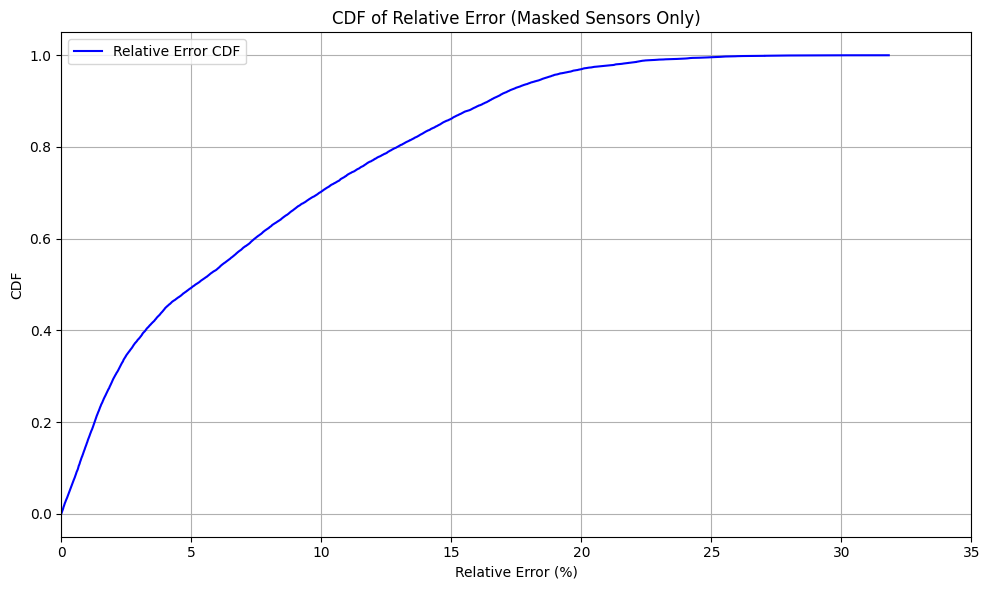

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 讀取資料
data = pd.read_csv('output_csv/output.csv')

# 蒐集所有與 mask_ 開頭的欄位（這些是 masked 的相對誤差）
mask_columns = [col for col in data.columns if col.startswith('mask_')]

# 合併所有 masked error，去除 NaN
all_errors = data[mask_columns].values.flatten()
all_errors = all_errors[~np.isnan(all_errors)]

# 計算 CDF
def compute_cdf(values):
    sorted_values = np.sort(values)
    cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    return sorted_values, cdf

error_sorted, error_cdf = compute_cdf(all_errors * 100)  # 轉換為百分比

# 計算平均與最大相對誤差（百分比）
mean_error = np.mean(all_errors) * 100
max_error = np.max(all_errors) * 100

# 印出結果
print(f'Average Relative Error: {mean_error:.2f}%')
print(f'Maximum Relative Error: {max_error:.2f}%')

# 繪製 CDF
plt.figure(figsize=(10, 6))
plt.plot(error_sorted, error_cdf, label='Relative Error CDF', color='blue')
plt.xlim(0, 35)
plt.title('CDF of Relative Error (Masked Sensors Only)')
plt.xlabel('Relative Error (%)')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd
import numpy as np

# 模擬讀取已計算好的 masked relative error（百分比）
data = pd.read_csv('output_csv/output.csv')
# data = pd.read_csv('output_csv_exp/output_4.csv')
# data = pd.read_csv('output_csv_cfd/output_4.csv')
# data = pd.read_csv('output_csv_ablation/output_2grid_fan.csv')
# 抓取所有 mask_ 開頭的欄位（表示 masked sensor 的相對誤差）
mask_columns = [col for col in data.columns if col.startswith('mask_')]
all_errors = data[mask_columns].values.flatten()
all_errors = all_errors[~np.isnan(all_errors)] * 100  # 移除 NaN 並轉換為百分比

# 計算各門檻的比例
thresholds = [2, 4, 5, 8, 20]
percent_below_threshold = {
    f"< {thresh}%": np.mean(all_errors < thresh) * 100 for thresh in thresholds
}

percent_below_threshold


{'< 2%': 29.41468253968254,
 '< 4%': 44.8859126984127,
 '< 5%': 49.30059523809524,
 '< 8%': 62.44047619047619,
 '< 20%': 96.95436507936508}

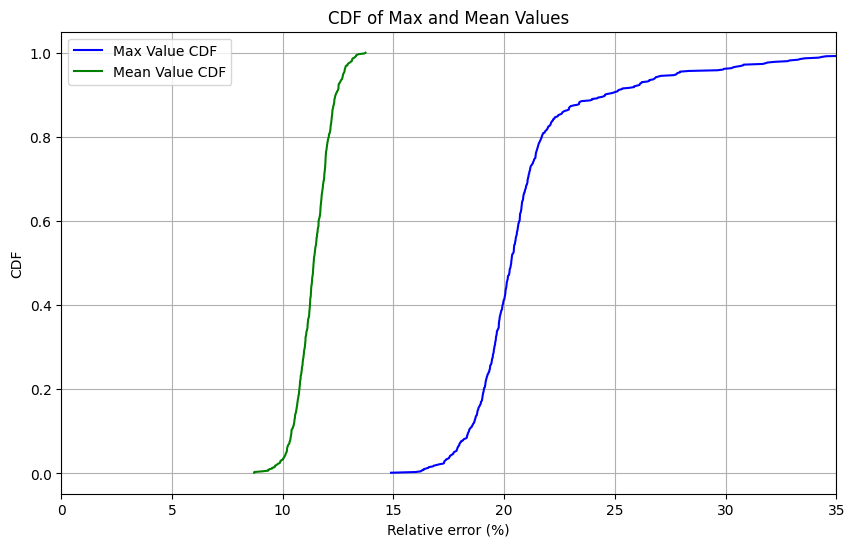

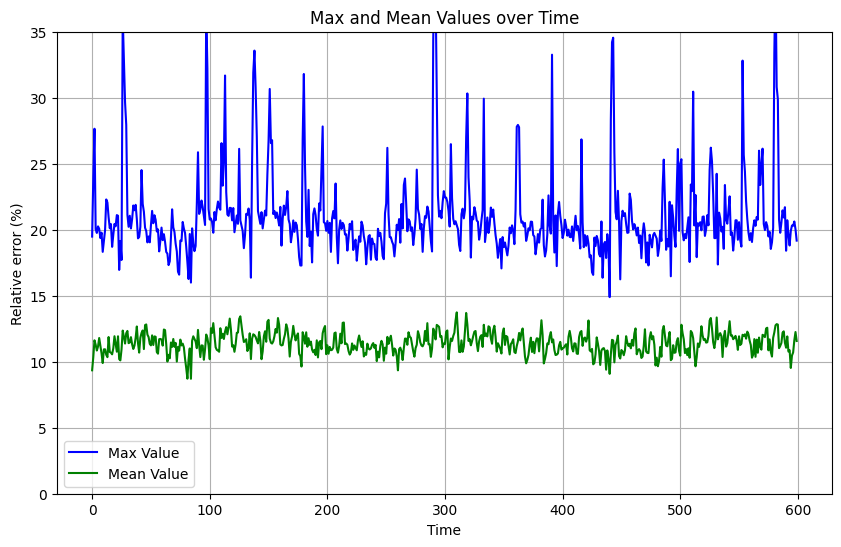

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設您的數據是存在一個 CSV 文件中，讀取它
data = pd.read_csv('output_csv/output.csv')

# 讀取 mean 和 max 欄位
mean_values = data['average']
max_values = data['max']

# 計算CDF
def compute_cdf(values):
    sorted_values = np.sort(values)
    cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    return sorted_values, cdf

# 計算max和mean的CDF
max_sorted, max_cdf = compute_cdf(max_values)
mean_sorted, mean_cdf = compute_cdf(mean_values)

# 將值轉換為百分比
max_sorted *= 100
mean_sorted *= 100

# 繪製CDF圖
plt.figure(figsize=(10, 6))
plt.plot(max_sorted, max_cdf, label='Max Value CDF', color='blue')
plt.plot(mean_sorted, mean_cdf, label='Mean Value CDF', color='green')

# 設置x軸範圍
plt.xlim(0, 35)

plt.title('CDF of Max and Mean Values')
plt.xlabel('Relative error (%)')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()

# 假設您的 CSV 中有時間列（如果沒有，可以使用索引代替）
time = data['time'] if 'time' in data.columns else np.arange(len(data))

# 轉換為百分比
max_values *= 100
mean_values *= 100

# 繪製 max 和 mean 隨時間變化的曲線
plt.figure(figsize=(10, 6))
plt.plot(time, max_values, label='Max Value', color='blue')
plt.plot(time, mean_values, label='Mean Value', color='green')
plt.ylim(0, 35)
plt.title('Max and Mean Values over Time')
plt.xlabel('Time')
plt.ylabel('Relative error (%)')
plt.legend()
plt.grid(True)
plt.show()


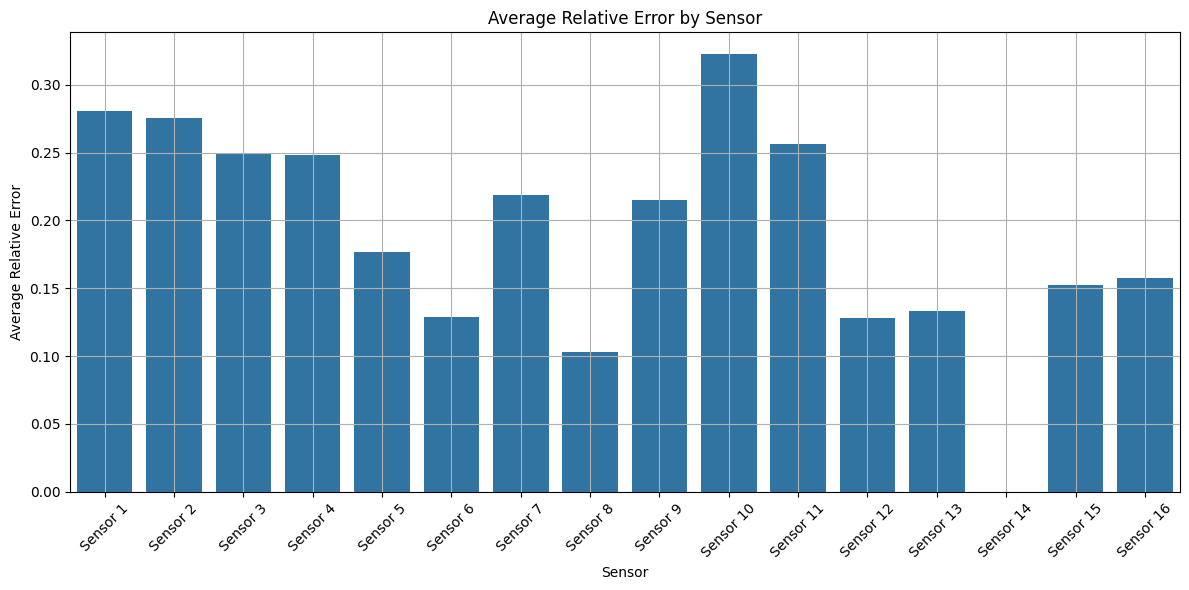

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 讀取剛剛輸出的結果
df = pd.read_csv("output_csv/output.csv")

# 取出 16 個 sensor 的錯誤
error_columns = [f"mask_{i+1}" for i in range(16)]
sensor_errors = df[error_columns]

# 計算每個 sensor 平均錯誤與標準差
avg_error = sensor_errors.max()
std_error = sensor_errors.std()

# 整理成新的 DataFrame
summary_df = pd.DataFrame({
    "Sensor": [f"Sensor {i+1}" for i in range(16)],
    "Average Relative Error": avg_error.values,
    "Std Dev": std_error.values
})

# 繪製 bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x="Sensor", y="Average Relative Error", data=summary_df)
plt.title("Average Relative Error by Sensor")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# import ace_tools as tools; tools.display_dataframe_to_user(name="Sensor Error Summary", dataframe=summary_df)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.animation as animation

# 載入資料
csv_path = "output_csv/output.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found: {csv_path}")

df = pd.read_csv(csv_path)
sensor_cols = [f"sensor{i+1}" for i in range(16)]
origin_cols = [f"origin_{i+1}" for i in range(16)]
mask_cols = [f"mask_{i+1}" for i in range(16)]

first_row = df.iloc[0]
masked_indices = [i for i, m in enumerate(mask_cols) if not pd.isna(first_row[m])]

# 輸出資料夾
frame_dir = "animation_gif_output"
os.makedirs(frame_dir, exist_ok=True)

# 動畫設定
total_frames = min(len(df), 288)     # 動畫長度 = 1440 frame
x_display_offset = 12961              # 顯示時間軸起點
# x_display_offset = 0 
ymin, ymax = 300, 1800


def create_sensor_animation(sensor_idx):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, total_frames)
    ax.set_ylim(ymin, ymax)

    line1, = ax.plot([], [], label='Origin', color='black')
    line2, = ax.plot([], [], label='Prediction', color='red')

    ax.set_title(f"Sensor {sensor_idx + 1} Prediction vs Origin")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("PPM Concentration")
    ax.grid(True)
    ax.legend()

    def update(frame):
        if frame < 2:
            return line1, line2

        x = np.arange(frame)
        y1 = df[origin_cols[sensor_idx]].iloc[:frame]
        y2 = df[sensor_cols[sensor_idx]].iloc[:frame]

        line1.set_data(x, y1)
        line2.set_data(x, y2)

        # 更新 X 軸顯示刻度為時間偏移後
        tick_locs = ax.get_xticks()
        ax.set_xticklabels([str(int(t + x_display_offset)) for t in tick_locs])

        return line1, line2

    ani = animation.FuncAnimation(fig, update, frames=total_frames, blit=True)

    mp4_path = os.path.join(frame_dir, f"sensor_{sensor_idx+1}.mp4")
    ani.save(mp4_path, writer='ffmpeg', fps=15)
    plt.close()

# 執行動畫產生
for idx in masked_indices:
    create_sensor_animation(idx)


/tmp/ipykernel_1037492/358105956.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(int(t + x_display_offset)) for t in tick_locs])
/tmp/ipykernel_1037492/358105956.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(int(t + x_display_offset)) for t in tick_locs])
/tmp/ipykernel_1037492/358105956.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(int(t + x_display_offset)) for t in tick_locs])
/tmp/ipykernel_1037492/358105956.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(int(t + x_display_offset)) for t in tick_locs])
/tmp/ipykernel_1037492/358105956.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(int(t + x_display_offset)) for t in tick_locs])
/tmp/ipykernel_1037492/358105956.py:58: UserWarning: Fi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter

# 載入資料
csv_path = "output_csv/output_5.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found: {csv_path}")

df = pd.read_csv(csv_path)
sensor_cols = [f"sensor{i+1}" for i in range(16)]
origin_cols = [f"origin_{i+1}" for i in range(16)]
mask_cols = [f"mask_{i+1}" for i in range(16)]

# 找出未被 mask 的感測器 index
first_row = df.iloc[0]
unmasked_indices = [i for i, m in enumerate(mask_cols) if pd.isna(first_row[m])]

# 輸出資料夾
frame_dir = "animation_gif_output"
os.makedirs(frame_dir, exist_ok=True)

# 動畫設定
total_frames = min(len(df), 288)
x_display_offset = 12961
# x_display_offset = 0
ymin, ymax = 300, 1800

def create_unmasked_animation():
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, total_frames)
    ax.set_ylim(ymin, ymax)

    lines = []
    for idx in unmasked_indices:
        line, = ax.plot([], [], label=f"Sensor {idx+1}")
        lines.append(line)

    ax.set_title("Unmasked Sensor Origins Over Time")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("PPM Concentration")
    ax.grid(True)
    ax.legend()

    def update(frame):
        if frame < 2:
            return lines

        x = np.arange(frame)
        for i, idx in enumerate(unmasked_indices):
            y = df[origin_cols[idx]].iloc[:frame]
            lines[i].set_data(x, y)

        tick_locs = ax.get_xticks()
        ax.set_xticklabels([str(int(t + x_display_offset)) for t in tick_locs])

        return lines

    ani = animation.FuncAnimation(fig, update, frames=total_frames, blit=True)

    writer = FFMpegWriter(fps=15, bitrate=2500)
    mp4_path = os.path.join(frame_dir, "unmasked_sensors.mp4")
    ani.save(mp4_path, writer=writer)
    plt.close()

# 執行
create_unmasked_animation()


/tmp/ipykernel_1037492/3048579293.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(int(t + x_display_offset)) for t in tick_locs])


In [ ]:
import os
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 準備資料
csv_path = "output_csv/output_5.csv"
df = pd.read_csv(csv_path)
origin_cols = [f"origin_{i+1}" for i in range(16)]
origin_data = df[origin_cols].values

os.makedirs("frames_exp", exist_ok=True)

for frame in range(origin_data.shape[0]):
    fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.05)
    
    origin_frame = origin_data[frame].reshape(4, 4)
    zoomed_image = zoom(origin_frame, (180/4, 90/4), order=3)

    norm = Normalize(vmin=300, vmax=1800)
    levels = np.linspace(300, 1800, 20)

    im = ax.imshow(zoomed_image, cmap='hot', norm=norm, origin='lower')
    contours = ax.contour(zoomed_image, levels=levels, colors='white', linewidths=0.5)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%d")
    ax.contour(zoomed_image, levels=levels, colors='white', linewidths=0.5)
    ax.set_xlabel("X Axis", fontsize=8)
    ax.set_ylabel("Y Axis", fontsize=8)
    ax.set_xlim(0, zoomed_image.shape[1])
    ax.set_ylim(0, zoomed_image.shape[0])
    ax.set_title(f"Frame {frame + 1}", fontsize=12)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_ticks(np.linspace(300, 1800, num=6))
    cbar.ax.set_yticklabels([f'{int(x)}' for x in np.linspace(300, 1800, num=6)])
    cbar.ax.tick_params(labelsize=7)

    fig.savefig(f"frames_exp/frame_{frame:04d}.png", bbox_inches='tight', pad_inches=0)
    plt.close(fig)


In [89]:
import imageio.v2 as imageio

images = []
for frame in range(origin_data.shape[0]):
    img = imageio.imread(f"frames_exp/frame_{frame:04d}.png")
    images.append(img)

imageio.mimsave("output_video_exp.mp4", images, fps=25)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (345, 523) to (352, 528) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6e26dc0] Warning: data is not aligned! This can lead to a speed loss


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 讀取資料
# csv_path = "output_csv_ablation/output_4.csv"

csv_path = "output_csv_CFD/output_5.csv"
df = pd.read_csv(csv_path)

sensor_cols = [f"sensor{i+1}" for i in range(16)]
origin_cols = [f"origin_{i+1}" for i in range(16)]
mask_cols = [f"mask_{i+1}" for i in range(16)]

first_row = df.iloc[0]
masked_indices = [i for i, m in enumerate(mask_cols) if not pd.isna(first_row[m])]

# 輸出資料夾
# output_dir = "final_frame_output"
output_dir = "final_frame_output_4-2-cfd"
os.makedirs(output_dir, exist_ok=True)

# 只畫最後結果 (masked sensors)
frame = len(df)
x = np.arange(frame)

for idx in masked_indices:
    y_pred = df[sensor_cols[idx]]
    y_origin = df[origin_cols[idx]]

    plt.figure(figsize=(10, 6))
    plt.plot(x, y_origin, label='Origin', color='black')
    plt.plot(x, y_pred, label='Prediction', color='red')
    
    plt.xlabel("Time Step", fontsize=18)
    plt.ylabel("PPM Concentration", fontsize=18)
    plt.ylim(0, 1800)
    plt.grid(True)
    plt.tick_params(axis='both', labelsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()
    
    save_path = os.path.join(output_dir, f"sensor_{idx+1}_final.png")
    plt.savefig(save_path)
    plt.close()

# 找出 unmasked 感測器
# 線型樣式
linestyles = ['-', '--', '-.', ':', (0, (5, 1)), (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (1, 1))]

# 顏色樣式
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf'
]

plt.figure(figsize=(10, 6))
# 找出 unmasked 感測器
unmasked_indices = [i for i, m in enumerate(mask_cols) if pd.isna(first_row[m])]

for idx, sensor_idx in enumerate(unmasked_indices):
    y = df[origin_cols[sensor_idx]]
    
    # 每條線用顏色 + 線型組合，避免重複
    color = colors[idx % len(colors)]
    linestyle = linestyles[idx % len(linestyles)]
    
    plt.plot(
        x, y,
        label=f"Sensor {sensor_idx+1}",
        color=color,
        linestyle=linestyle
    )

plt.xlabel("Time Step", fontsize=18)
plt.ylabel("PPM Concentration", fontsize=18)
plt.ylim(0, 1800)
plt.grid(True)
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

save_path = os.path.join(output_dir, "unmasked_sensors_final.png")
plt.savefig(save_path)
plt.close()



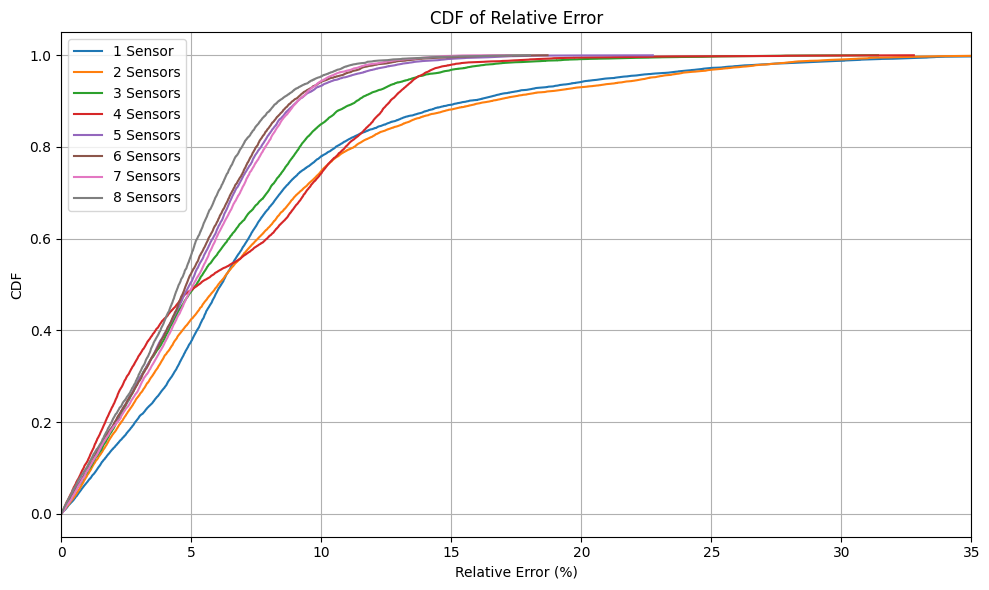

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 設定檔案與對應標籤
file_map = {
    # "output_1_fan.csv": "1 Sensor",
    # "output_2_fan.csv": "2 Sensors",
    # "output_3_fan.csv": "3 Sensors",
    # "output_4_fan.csv": "4 Sensors",
    # "output_5_fan.csv": "5 Sensors",
    # "output_6_fan.csv": "6 Sensors",
    # "output_7_fan.csv": "7 Sensors",
    # "output_8_fan.csv": "8 Sensors",
    # "output_8grid_fan.csv": "8 Sensors(Grid)",
    # "output_4grid_fan.csv": "4 Sensors(Grid)",
    # "output_2grid_fan.csv": "2 Sensors(Grid)",
    "output_1.csv": "1 Sensor",
    "output_2.csv": "2 Sensors",
    "output_3.csv": "3 Sensors",
    "output_4.csv": "4 Sensors",
    "output_5.csv": "5 Sensors",
    "output_6.csv": "6 Sensors",
    "output_7.csv": "7 Sensors",
    "output_8.csv": "8 Sensors",
    # "output_8grid.csv": "8 Sensors(Grid)",
    # "output_4grid.csv": "4 Sensors(Grid)",
    # "output_2grid.csv": "2 Sensors(Grid)",
}

# 計算 CDF 的函數
def compute_cdf(values):
    sorted_values = np.sort(values)
    cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    return sorted_values, cdf

# 繪圖
plt.figure(figsize=(10, 6))

# 處理每個策略檔案
for file_name, label in file_map.items():
    data = pd.read_csv(f"output_csv_EXP/{file_name}")
    mask_columns = [col for col in data.columns if col.startswith('mask_')]
    all_errors = data[mask_columns].values.flatten()
    all_errors = all_errors[~np.isnan(all_errors)]

    error_sorted, error_cdf = compute_cdf(all_errors * 100)
    plt.plot(error_sorted, error_cdf, label=label)

# 圖表設定
plt.xlim(0, 35)
plt.title('CDF of Relative Error')
plt.xlabel('Relative Error (%)')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


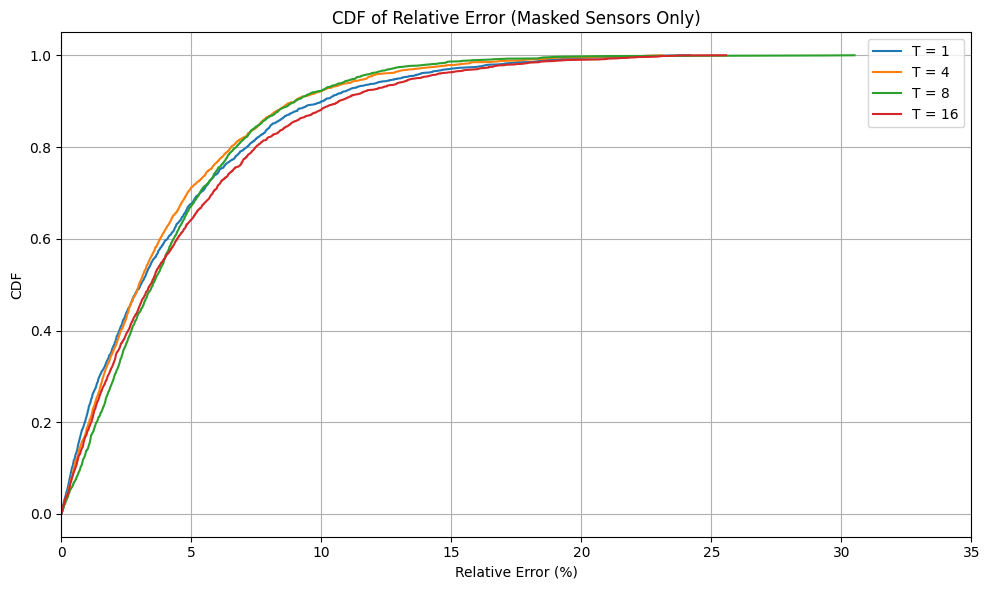

In [443]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 設定檔案與對應標籤
file_map = {
    "output_grid_t=1.csv": "T = 1",
    "output_grid_t=4.csv": "T = 4",
    "output_grid_t=8.csv": "T = 8",
    "output_grid_t=16.csv": "T = 16",
}

# 計算 CDF 的函數
def compute_cdf(values):
    sorted_values = np.sort(values)
    cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    return sorted_values, cdf

# 繪圖
plt.figure(figsize=(10, 6))

# 處理每個策略檔案
for file_name, label in file_map.items():
    data = pd.read_csv(f"output_csv/{file_name}")
    mask_columns = [col for col in data.columns if col.startswith('mask_')]
    all_errors = data[mask_columns].values.flatten()
    all_errors = all_errors[~np.isnan(all_errors)]

    error_sorted, error_cdf = compute_cdf(all_errors * 100)
    plt.plot(error_sorted, error_cdf, label=label)

# 圖表設定
plt.xlim(0, 35)
plt.title('CDF of Relative Error (Masked Sensors Only)')
plt.xlabel('Relative Error (%)')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


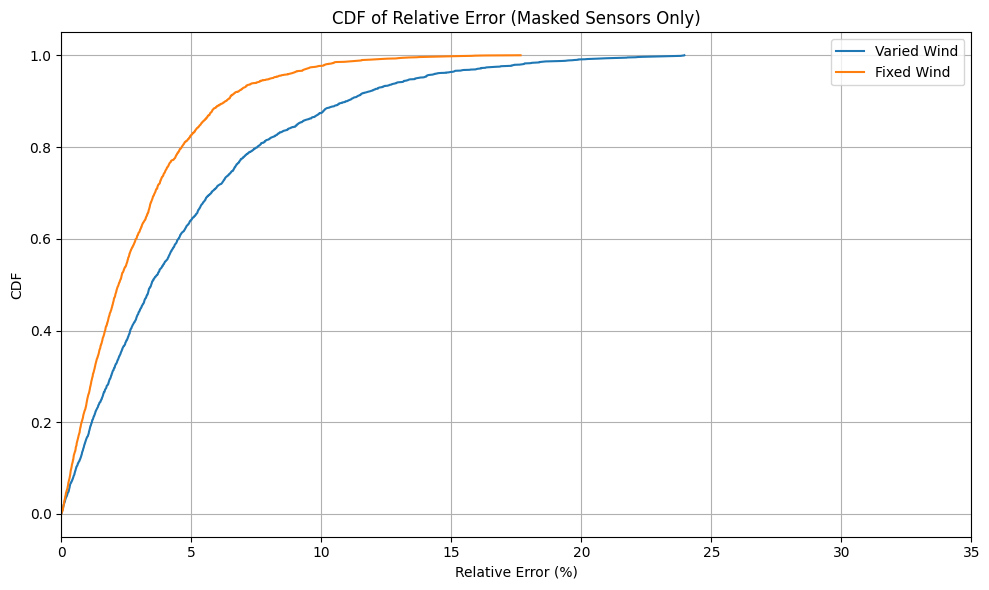

In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 設定檔案與對應標籤
file_map = {
    "output_new_grid.csv": "Varied Wind",
    "output_base_grid.csv": "Fixed Wind",
}

# 計算 CDF 的函數
def compute_cdf(values):
    sorted_values = np.sort(values)
    cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    return sorted_values, cdf

# 繪圖
plt.figure(figsize=(10, 6))

# 處理每個策略檔案
for file_name, label in file_map.items():
    data = pd.read_csv(f"output_csv/{file_name}")
    mask_columns = [col for col in data.columns if col.startswith('mask_')]
    all_errors = data[mask_columns].values.flatten()
    all_errors = all_errors[~np.isnan(all_errors)]

    error_sorted, error_cdf = compute_cdf(all_errors * 100)
    plt.plot(error_sorted, error_cdf, label=label)

# 圖表設定
plt.xlim(0, 35)
plt.title('CDF of Relative Error (Masked Sensors Only)')
plt.xlabel('Relative Error (%)')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


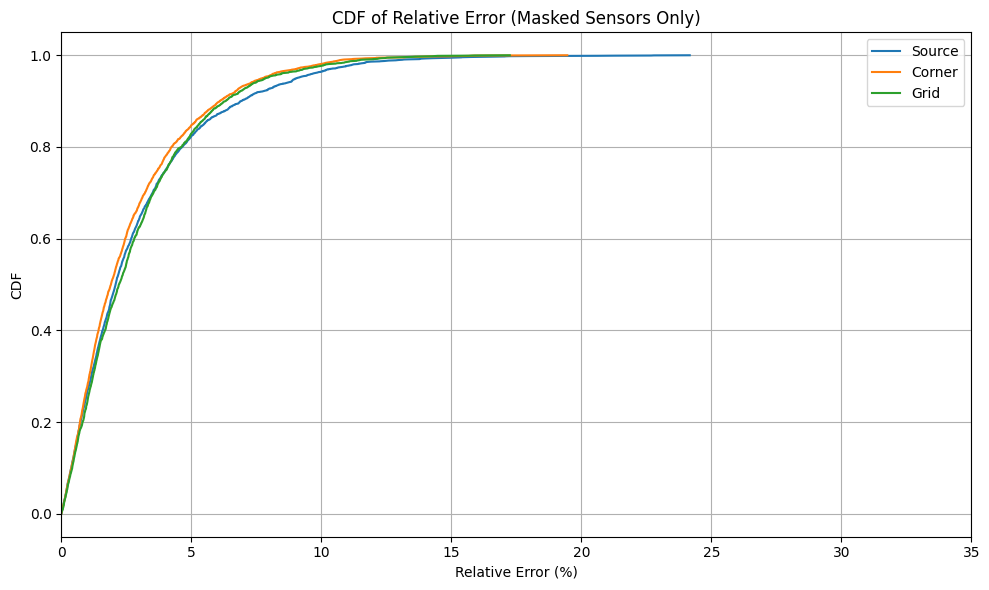

In [400]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 設定檔案與對應標籤
file_map = {
    "output_source.csv": "Source",
    "output_corner.csv": "Corner",
    "output_grid.csv": "Grid"
}

# 計算 CDF 的函數
def compute_cdf(values):
    sorted_values = np.sort(values)
    cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    return sorted_values, cdf

# 繪圖
plt.figure(figsize=(10, 6))

# 處理每個策略檔案
for file_name, label in file_map.items():
    data = pd.read_csv(f"output_csv/{file_name}")
    mask_columns = [col for col in data.columns if col.startswith('mask_')]
    all_errors = data[mask_columns].values.flatten()
    all_errors = all_errors[~np.isnan(all_errors)]

    error_sorted, error_cdf = compute_cdf(all_errors * 100)
    plt.plot(error_sorted, error_cdf, label=label)

# 圖表設定
plt.xlim(0, 35)
plt.title('CDF of Relative Error (Masked Sensors Only)')
plt.xlabel('Relative Error (%)')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


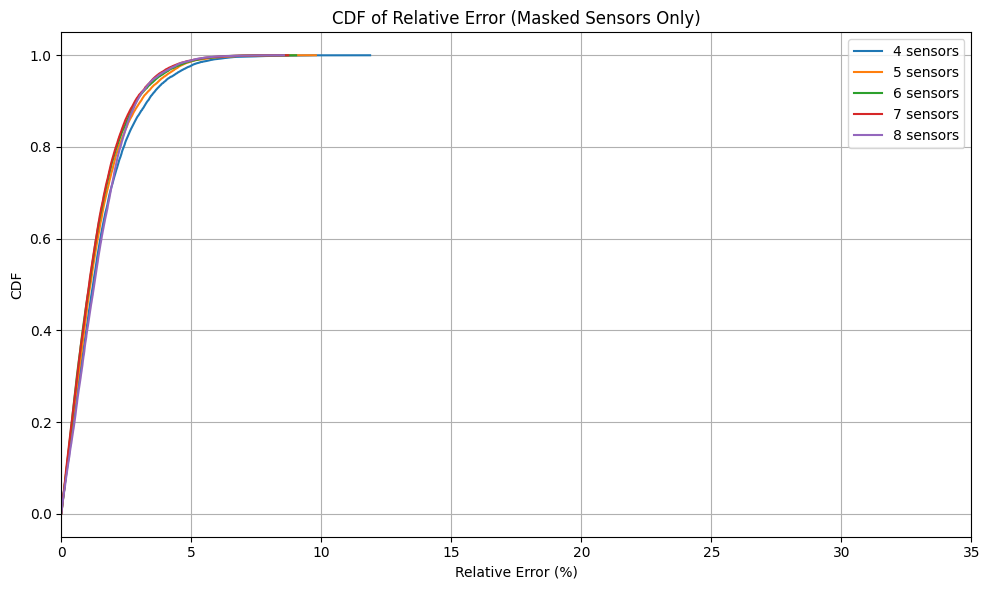

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 設定檔案名稱列表
file_names = [f'output_csv_fan_base/output_{i}.csv' for i in range(4, 9)]

# 計算 CDF 的函數
def compute_cdf(values):
    sorted_values = np.sort(values)
    cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    return sorted_values, cdf

# 繪圖
plt.figure(figsize=(10, 6))

# 處理每一個檔案
for i, file_name in enumerate(file_names, start=4):
    data = pd.read_csv(file_name)
    mask_columns = [col for col in data.columns if col.startswith('mask_')]
    all_errors = data[mask_columns].values.flatten()
    all_errors = all_errors[~np.isnan(all_errors)]
    
    error_sorted, error_cdf = compute_cdf(all_errors * 100)
    plt.plot(error_sorted, error_cdf, label=f'{i} sensors')

# 圖表設定
plt.xlim(0, 35)
plt.title('CDF of Relative Error (Masked Sensors Only)')
plt.xlabel('Relative Error (%)')
plt.ylabel('CDF')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


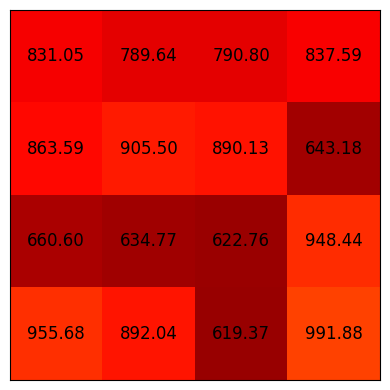

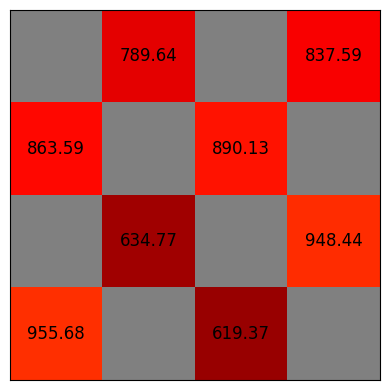

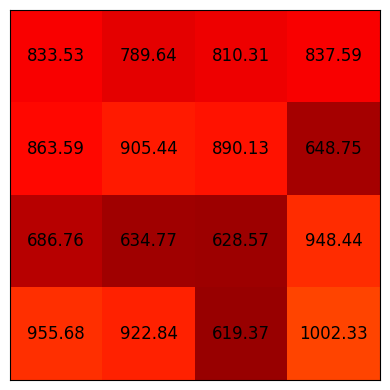

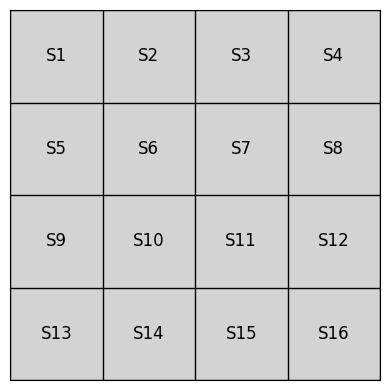

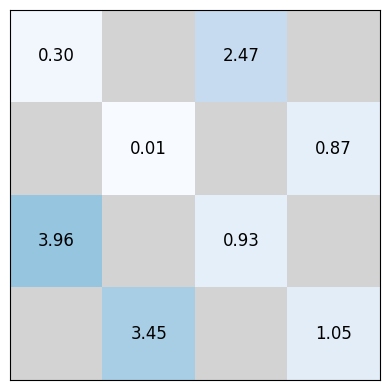

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 讀取資料 ===
df = pd.read_csv("output_csv/output.csv")

# === 欄位定義 ===
origin_cols = [f"origin_{i}" for i in range(1, 17)]
mask_cols = [f"mask_{i}" for i in range(1, 17)]
pred_cols = [f"sensor{i}" for i in range(1, 17)]

# === 讀取第一筆 ===
row = df.iloc[10]
origin = row[origin_cols].astype(float).values.reshape(4, 4)
mask = row[mask_cols].astype(float).fillna(0).values.reshape(4, 4)
prediction = row[pred_cols].astype(float).values.reshape(4, 4)

# === 原邏輯：有感測器用 origin，沒感測器填 0
masked_input = np.where(mask == 0, origin, 0)

# === 強制 0 的地方顯示為灰色（使用 masked array）
masked_input_ma = np.ma.masked_where(masked_input == 0, masked_input)

# === 自訂 colormap，遮罩顏色為灰色
cmap_hot = plt.cm.hot.copy()
cmap_hot.set_bad(color='gray')

# === 畫圖函式（左上角為 0,0，數字皆為黑色）===
def plot_grid(data, title, cmap='hot', show_value=True, vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(data, cmap=cmap, origin='upper', vmin=vmin, vmax=vmax)

    if show_value:
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                val = data[i, j]
                if not np.ma.is_masked(val):
                    ax.text(j, i, f"{val:.2f}", va='center', ha='center', color='black', fontsize=12)

    # plt.title(title)
    # plt.colorbar(im, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def plot_sensor_index_grid(title="Sensor Index Map"):
    fig, ax = plt.subplots(figsize=(4, 4))

    # 全 NaN array => 套用 masked 灰色
    gray_grid = np.full((4, 4), np.nan)
    gray_masked = np.ma.masked_invalid(gray_grid)

    # 使用灰色 colormap 並設 masked 為 lightgray
    cmap = plt.cm.Greys.copy()
    cmap.set_bad(color='lightgray')

    im = ax.imshow(gray_masked, cmap=cmap, origin='upper', vmin=0, vmax=1)

    # === 加上格線 ===
    ax.set_xticks(np.arange(-0.5, 4, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 4, 1), minor=True)
    ax.grid(which='minor', color='black', linewidth=1)
    ax.tick_params(which='minor', bottom=False, left=False)

    # 移除主刻度與標籤
    ax.set_xticks([])
    ax.set_yticks([])

    # 每格標示 S1~S16（從左上開始，行優先）
    for i in range(4):
        for j in range(4):
            sensor_num = i * 4 + j + 1
            ax.text(j, i, f"S{sensor_num}", va='center', ha='center', color='black', fontsize=12)

    # plt.title(title)
    plt.tight_layout()
    plt.show()


# === 固定顏色範圍 ===
vmin = 300
vmax = 1800

# === 畫圖 ===
plot_grid(origin, "Original", cmap='hot', vmin=vmin, vmax=vmax)
plot_grid(masked_input_ma, "Masked Input", cmap=cmap_hot, vmin=vmin, vmax=vmax)
plot_grid(prediction, "Prediction", cmap='hot', vmin=vmin, vmax=vmax)
plot_sensor_index_grid()


# === 計算相對誤差 ===
mask_bool = (mask > 0)  # 有遮蔽的位置（填入的是預測值）
truth = origin
rel_error = np.zeros_like(truth)

rel_error[mask_bool] = np.abs((prediction[mask_bool] - truth[mask_bool]) / truth[mask_bool])
rel_error = rel_error *100

# === 建立 masked array，只有遮蔽位置顯示，其它為灰色 ===
rel_error_masked = np.ma.masked_where(~mask_bool, rel_error)

# === 自訂藍色 colormap，遮蔽部分為灰色 ===
cmap_blue = plt.cm.Blues.copy()
cmap_blue.set_bad(color='lightgray')

# === 顯示誤差圖 ===
plot_grid(rel_error_masked, "Relative Error", cmap=cmap_blue, vmin=0, vmax=10)


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import re
from copy import deepcopy
import models_mae

def prepare_model(chkpt_dir, arch='mae_vit_base_patch1', **kwargs):
    model = getattr(models_mae, arch)(**kwargs)
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print("[Loaded]", msg)
    model.eval()
    return model

def inverse_normalize(log_normalized_values):
    original_min = 300
    original_max = 1600
    log_values = log_normalized_values * (np.log(original_max) - np.log(original_min)) + np.log(original_min)
    return np.exp(log_values)

def run_one_clip(clip_np, model, mask_ratio=0.5, custom_mask=None):
    frames_tensor = torch.tensor(clip_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, T, H, W)

    with torch.no_grad():
        loss, pred, mask = model(frames_tensor, mask_ratio=mask_ratio, custom_mask=custom_mask)

    pred_img = model.unpatchify(pred).detach().cpu()          # (1, 1, T_pred, H, W)
    mask = mask.detach().unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2)
    mask = model.unpatchify(mask).detach().cpu()              # (1, 1, T_pred, H, W)

    im_paste = frames_tensor * (1 - mask) + pred_img * mask

    T_pred = model.pred_t_dim
    original = frames_tensor[0, 0, :T_pred].numpy()
    predicted = im_paste[0, 0, :T_pred].numpy()
    mask_np = mask[0, 0, :T_pred].numpy()

    orig_inv = inverse_normalize(original.flatten()).reshape(original.shape)
    pred_inv = inverse_normalize(predicted.flatten()).reshape(predicted.shape)

    relative_error = np.abs((orig_inv - pred_inv) / orig_inv)
    relative_error[mask_np != 1] = np.nan

    return orig_inv, pred_inv, relative_error, mask_np

def search_best_masks(model, csv_files, num_frames, step):
    best_mask_list = []
    all_best_results = []

    total_sensors = 16
    available_indices = set(range(total_sensors))

    current_mask = torch.ones(total_sensors, dtype=torch.int)

    for num_masked in range(1, 9):  # mask 數量從 1 到 8
        best_max_error = float('inf')
        best_mask = None
        best_result = None

        for idx in available_indices:
            temp_mask = deepcopy(current_mask)
            temp_mask[idx] = 0  # 試著 mask 這個 sensor

            total_max = []
            for i in range(0, len(csv_files) - num_frames + 1, step):
                files = csv_files[i:i+num_frames]
                clip = [np.genfromtxt(f, delimiter=',') for f in files]
                clip_np = np.stack(clip)

                orig, pred, err, mask_np = run_one_clip(clip_np, model, mask_ratio=0.5, custom_mask=temp_mask)
                for t in range(model.pred_t_dim):
                    err_flat = err[t].flatten()
                    total_max.append(np.nanmax(err_flat))

            avg_max_error = np.nanmean(total_max)
            if avg_max_error < best_max_error:
                best_max_error = avg_max_error
                best_mask = temp_mask.clone()
                best_result = {
                    'mask': best_mask.numpy().tolist(),
                    'avg_max_error': best_max_error,
                    'num_masked': num_masked
                }

        # 儲存本輪最佳 mask 與結果
        best_mask_list.append(best_mask.numpy().tolist())
        all_best_results.append(best_result)

        # 更新 current_mask 與 available_indices
        current_mask = best_mask.clone()
        available_indices = set(i for i in available_indices if current_mask[i] == 1)

        # print(f"✅ Mask {num_masked}: Best mask = {best_mask.numpy().tolist()}")
        print(f"torch.tensor({best_mask.numpy().tolist()}, dtype=torch.int)")

    return all_best_results


# === Main Execution ===
# data_dir = 'cfd_dataset_origin/53_ablation/test'
# data_dir = 'cfd_dataset_origin/test' #result CFD
data_dir = 'biya_cfd_data/test_new'   # ablation study fan
save_path = 'output_csv'
os.makedirs(save_path, exist_ok=True)

sampling_rate = 5
csv_files = sorted([
    os.path.join(data_dir, f)
    for f in os.listdir(data_dir)
    if f.endswith('.csv')
], key=lambda path: int(re.match(r".*_(\d+)", os.path.basename(path)).group(1)))[::sampling_rate]

model = prepare_model(
    # 'output_dir_ablation53/checkpoint-00200.pth',
    # 'output_dir_ablation53/checkpoint-00800.pth',
    # 'origin_cfd_output_16/checkpoint-00200.pth',
    # 'output_dir_ablation53_notransfer/checkpoint-00200.pth',

    'output_dir_25-75/checkpoint-00200.pth',
    arch='mae_vit_base_patch1',
    in_chans=1,
    t_patch_size=1,
    pred_t_dim=8,
    num_frames=8,
)

num_frames = 8
step = model.pred_t_dim

# ✅ 搜尋每一層 mask 下最好的 sensor 組合
all_best_results = search_best_masks(model, csv_files, num_frames, step)

# ✅ 儲存結果
df_best = pd.DataFrame(all_best_results)
df_best.to_csv(os.path.join(save_path, "greedy_best_mask_1to8.csv"), index=False)
print("🎉 所有最佳 mask 組合與錯誤率已儲存到 greedy_best_mask_1to8.csv")


img_size (4, 4) patch_size (1, 1) frames 8 t_patch_size 1
model initialized
[Loaded] <All keys matched successfully>
torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=torch.int)
torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1], dtype=torch.int)
torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0], dtype=torch.int)
torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0], dtype=torch.int)
torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0], dtype=torch.int)
torch.tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0], dtype=torch.int)
torch.tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0], dtype=torch.int)
torch.tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0], dtype=torch.int)
🎉 所有最佳 mask 組合與錯誤率已儲存到 greedy_best_mask_1to8.csv


In [3]:
import os
import torch
import numpy as np
import pandas as pd
import re
import itertools
from copy import deepcopy
import models_mae

def prepare_model(chkpt_dir, arch='mae_vit_base_patch1', **kwargs):
    model = getattr(models_mae, arch)(**kwargs)
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print("[Loaded]", msg)
    model.eval()
    return model

def inverse_normalize(log_normalized_values):
    original_min = 370
    original_max = 1800
    log_values = log_normalized_values * (np.log(original_max) - np.log(original_min)) + np.log(original_min)
    return np.exp(log_values)

def run_one_clip(clip_np, model, mask_ratio=0.5, custom_mask=None):
    frames_tensor = torch.tensor(clip_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    with torch.no_grad():
        loss, pred, mask = model(frames_tensor, mask_ratio=mask_ratio, custom_mask=custom_mask)

    pred_img = model.unpatchify(pred).detach().cpu()
    mask = mask.detach().unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2)
    mask = model.unpatchify(mask).detach().cpu()

    im_paste = frames_tensor * (1 - mask) + pred_img * mask

    T_pred = model.pred_t_dim
    original = frames_tensor[0, 0, :T_pred].numpy()
    predicted = im_paste[0, 0, :T_pred].numpy()
    mask_np = mask[0, 0, :T_pred].numpy()

    orig_inv = inverse_normalize(original.flatten()).reshape(original.shape)
    pred_inv = inverse_normalize(predicted.flatten()).reshape(predicted.shape)

    relative_error = np.abs((orig_inv - pred_inv) / orig_inv)
    relative_error[mask_np != 1] = np.nan

    return orig_inv, pred_inv, relative_error, mask_np

def evaluate_fixed_mask_size(model, csv_files, num_frames, step, fixed_mask_count):
    total_sensors = 16
    all_indices = list(range(total_sensors))
    all_combinations = list(itertools.combinations(all_indices, fixed_mask_count))
    all_results = []

    for mask_indices in all_combinations:
        temp_mask = torch.ones(total_sensors, dtype=torch.int)
        temp_mask[list(mask_indices)] = 0

        total_max = []
        for i in range(0, len(csv_files) - num_frames + 1, step):
            files = csv_files[i:i+num_frames]
            clip = [np.genfromtxt(f, delimiter=',') for f in files]
            clip_np = np.stack(clip)

            orig, pred, err, mask_np = run_one_clip(clip_np, model, mask_ratio=0.5, custom_mask=temp_mask)
            for t in range(model.pred_t_dim):
                err_flat = err[t].flatten()
                total_max.append(np.nanmax(err_flat))

        avg_max_error = np.nanmean(total_max)
        result = {
            'mask': temp_mask.numpy().tolist(),
            'avg_max_error': avg_max_error,
            'num_masked': fixed_mask_count
        }
        print(f"Mask {fixed_mask_count}: {temp_mask.numpy().tolist()} => MaxErr: {avg_max_error:.4f}")
        all_results.append(result)

    return all_results

# === Main Execution ===
if __name__ == "__main__":
    data_dir = 'biya_cfd_data/test_base'
    save_path = 'output_csv'
    os.makedirs(save_path, exist_ok=True)

    sampling_rate = 100
    csv_files = sorted([
        os.path.join(data_dir, f)
        for f in os.listdir(data_dir)
        if f.endswith('.csv')
    ], key=lambda path: int(re.match(r".*_(\d+)", os.path.basename(path)).group(1)))[::sampling_rate]

    model = prepare_model(
        'fan_cfd_output_8/checkpoint-00200.pth',
        arch='mae_vit_base_patch1',
        in_chans=1,
        t_patch_size=1,
        pred_t_dim=8,
        num_frames=8,
    )

    num_frames = 8
    step = model.pred_t_dim
    fixed_mask_count = 4  # <<== 可改成你要測試的遮罩數量

    all_results = evaluate_fixed_mask_size(model, csv_files, num_frames, step, fixed_mask_count)
    df_result = pd.DataFrame(all_results)
    df_result.to_csv(os.path.join(save_path, f"all_mask_combinations_{fixed_mask_count}.csv"), index=False)

    print("✅ 所有固定遮罩數量的組合與錯誤率已儲存。")


img_size (4, 4) patch_size (1, 1) frames 8 t_patch_size 1
model initialized
[Loaded] <All keys matched successfully>
Mask 4: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] => MaxErr: 0.1033
Mask 4: [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] => MaxErr: 0.0943
Mask 4: [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] => MaxErr: 0.0851
Mask 4: [0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1] => MaxErr: 0.0969
Mask 4: [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1] => MaxErr: 0.1162
Mask 4: [0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1] => MaxErr: 0.1314
Mask 4: [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1] => MaxErr: 0.1439
Mask 4: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1] => MaxErr: 0.1584
Mask 4: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1] => MaxErr: 0.1340
Mask 4: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1] => MaxErr: 0.1391
Mask 4: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1] => MaxErr: 0.1408
Mask 4: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1] =

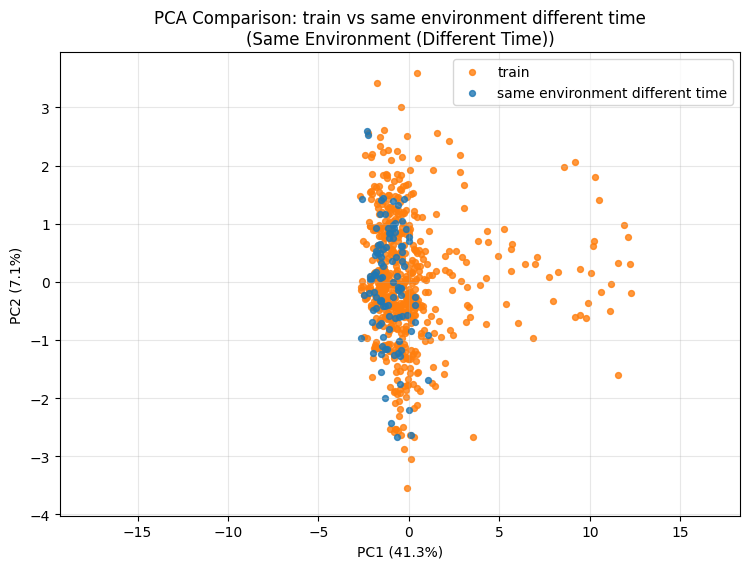

[Same Environment (Different Time)] 2D-PCA Overlap = 0.8558  (0=不重疊, 1=完全重疊)


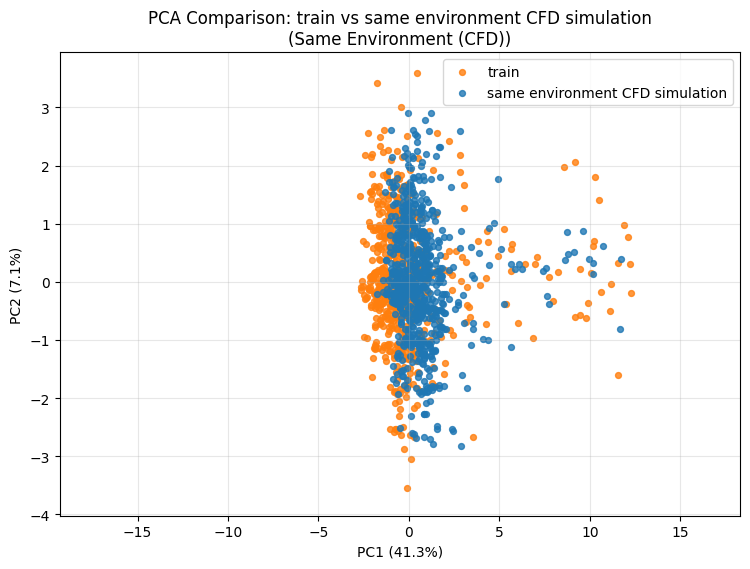

[Same Environment (CFD)] 2D-PCA Overlap = 0.5923  (0=不重疊, 1=完全重疊)


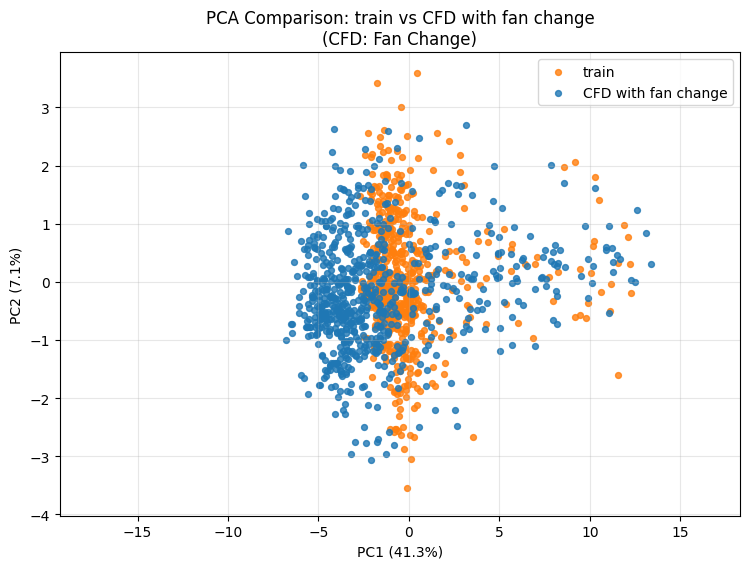

[CFD: Fan Change] 2D-PCA Overlap = 0.2330  (0=不重疊, 1=完全重疊)


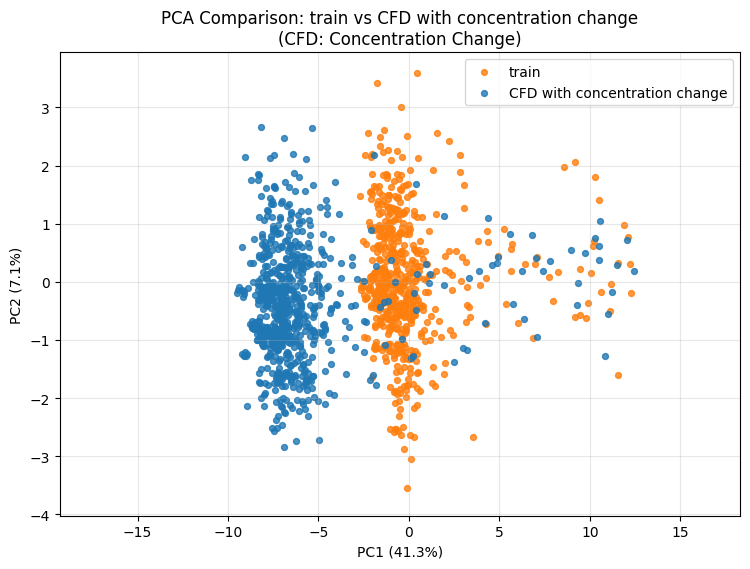

[CFD: Concentration Change] 2D-PCA Overlap = 0.0306  (0=不重疊, 1=完全重疊)


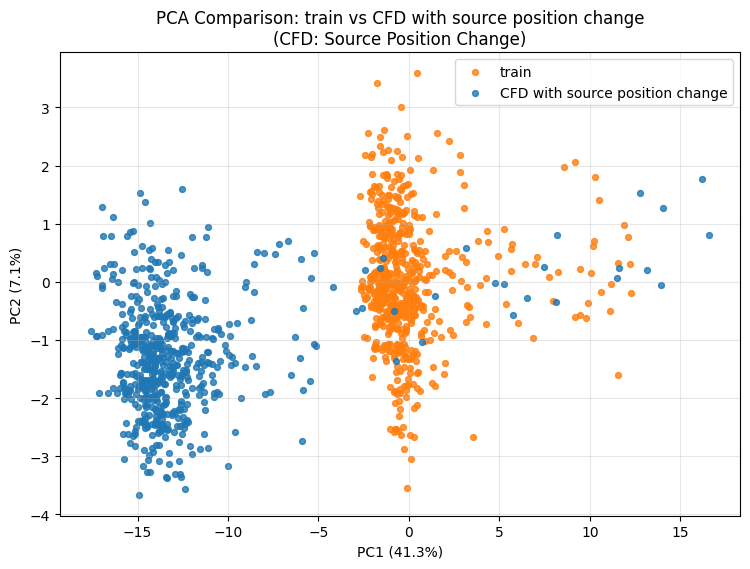

[CFD: Source Position Change] 2D-PCA Overlap = 0.0122  (0=不重疊, 1=完全重疊)
Saved summary to pca_out/overlap_summary.csv


In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

# ---------- 2D 直方圖重疊係數 ----------
def overlap_fraction_relative_to_train(Z_train, Z_target, bins=50):
    x_lo = min(Z_train[:,0].min(), Z_target[:,0].min())
    x_hi = max(Z_train[:,0].max(), Z_target[:,0].max())
    y_lo = min(Z_train[:,1].min(), Z_target[:,1].min())
    y_hi = max(Z_train[:,1].max(), Z_target[:,1].max())

    H_train, x_edges, y_edges = np.histogram2d(
        Z_train[:,0], Z_train[:,1],
        bins=bins, range=[[x_lo, x_hi], [y_lo, y_hi]], density=False
    )
    train_mask = H_train > 0

    H_target, _, _ = np.histogram2d(
        Z_target[:,0], Z_target[:,1],
        bins=[x_edges, y_edges], density=False
    )

    target_in_train = np.sum(H_target[train_mask])
    target_total = len(Z_target)
    return target_in_train / target_total

# ---------- 繪圖（固定 PCA 與座標範圍；使用 train 標準化 + PCA） ----------
def plot_with_fixed_train(pca_model, Z_train, df_target, common_cols,
                          scaler, label_train, label_target, xlim, ylim,
                          title_suffix=None, save=False, outpng=None, bins=50,
                          pc1_var=None, pc2_var=None):
    # 用同一個 scaler 標準化 target，再投影
    Xb_raw = df_target[common_cols].dropna().values
    Xb = scaler.transform(Xb_raw)
    Z_target = pca_model.transform(Xb)

    plt.figure(figsize=(7.6, 5.8))
    plt.scatter(Z_train[:,0],  Z_train[:,1],  s=18, alpha=0.8, label=label_train,  c='C1')
    plt.scatter(Z_target[:,0], Z_target[:,1], s=18, alpha=0.8, label=label_target, c='C0')

    if pc1_var is not None and pc2_var is not None:
        xlabel = f"PC1 ({pc1_var:.1f}%)"
        ylabel = f"PC2 ({pc2_var:.1f}%)"
    else:
        xlabel, ylabel = "PC1", "PC2"

    title = f"PCA Comparison: {label_train} vs {label_target}"
    if title_suffix: title += f"\n({title_suffix})"
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3); plt.legend()
    plt.xlim(*xlim); plt.ylim(*ylim)
    plt.tight_layout()
    if save and outpng:
        os.makedirs(os.path.dirname(outpng), exist_ok=True)
        plt.savefig(outpng, dpi=200)
    plt.show()

    ovl2d = overlap_fraction_relative_to_train(Z_train, Z_target, bins=bins)
    return ovl2d

# ---------- 主流程 ----------
outdir = "pca_out"
os.makedirs(outdir, exist_ok=True)

# 檔案路徑
train_file = "output_csv/output_train.csv"
targets = [
    ("output_csv/output_EXP_test.csv",               "same environment different time",    "Same Environment (Different Time)",    "train_vs_EXP_diff_time"),
    ("output_csv/output_same_cfd_test.csv",          "same environment CFD simulation",    "Same Environment (CFD)",               "train_vs_CFD_same"),
    ("output_csv/output_fan_change_cfd_test.csv",    "CFD with fan change",                "CFD: Fan Change",                      "train_vs_CFD_fan_change"),
    ("output_csv/output_con_change_cfd_test.csv",    "CFD with concentration change",      "CFD: Concentration Change",            "train_vs_CFD_con_change"),
    ("output_csv/output_position_change_cfd_test.csv","CFD with source position change",   "CFD: Source Position Change",          "train_vs_CFD_pos_change"),
]

# 讀檔
df_train = pd.read_csv(train_file)
dfs_target = [(lbl, title, tag, pd.read_csv(path)) for (path, lbl, title, tag) in targets]

# 找共同 sensor 欄位（train + 所有 target 的交集）
def sensor_cols(df): return [c for c in df.columns if c.lower().startswith('sensor')]
common_cols = set(sensor_cols(df_train))
for _, _, _, df_t in dfs_target:
    common_cols &= set(sensor_cols(df_t))
common_cols = sorted(common_cols)
if not common_cols:
    raise ValueError("沒有共同的 sensor_* 欄位，請檢查所有檔案的欄位一致性。")

# ====== 關鍵差異：對 train 標準化，固定 scaler 與 PCA ======
X_train_raw = df_train[common_cols].dropna().values

# 1) 用 train fit 標準化器；後續 target 也用這個 scaler
scaler = StandardScaler().fit(X_train_raw)
X_train = scaler.transform(X_train_raw)

# 2) 用標準化後的 train fit PCA；固定這個 pca_model
pca_model = PCA(n_components=2).fit(X_train)

# 3) 取得 train 的投影（這會和你「單張 train」的外觀一致）
Z_train = pca_model.transform(X_train)

# 解釋變異比例（讓座標軸標示跟單張一致）
exp_var = pca_model.explained_variance_ratio_
pc1_var = exp_var[0] * 100.0
pc2_var = exp_var[1] * 100.0

# 先把所有 target 的投影算好（也先標準化！）以決定「全域」座標範圍
Z_targets_tmp = []
for _, _, _, df_t in dfs_target:
    Xt_raw = df_t[common_cols].dropna().values
    Xt = scaler.transform(Xt_raw)              # ★ 同一個 scaler
    Zt = pca_model.transform(Xt)               # ★ 同一個 PCA
    Z_targets_tmp.append(Zt)

Z_all_tmp = np.vstack([Z_train] + Z_targets_tmp)
xpad = 0.05 * (Z_all_tmp[:,0].ptp() + 1e-9)
ypad = 0.05 * (Z_all_tmp[:,1].ptp() + 1e-9)
xlim = (Z_all_tmp[:,0].min() - xpad, Z_all_tmp[:,0].max() + xpad)
ylim = (Z_all_tmp[:,1].min() - ypad, Z_all_tmp[:,1].max() + ypad)

# 逐一繪圖與輸出 overlap
rows = []
for (path, label_b, title_suffix, tag), (_, _, _, df_t) in zip(targets, dfs_target):
    ovl = plot_with_fixed_train(
        pca_model, Z_train, df_t, common_cols,
        scaler=scaler, label_train="train", label_target=label_b,
        xlim=xlim, ylim=ylim,
        title_suffix=title_suffix,
        save=True, outpng=f"{outdir}/{tag}.png",
        bins=50,
        pc1_var=pc1_var, pc2_var=pc2_var
    )
    print(f"[{title_suffix}] 2D-PCA Overlap = {ovl:.4f}  (0=不重疊, 1=完全重疊)")
    rows.append({"target": tag, "label": label_b, "title": title_suffix, "overlap_2d": ovl})

# 存成 CSV 摘要
pd.DataFrame(rows).to_csv(f"{outdir}/overlap_summary.csv", index=False)
print(f"Saved summary to {outdir}/overlap_summary.csv")
